In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import geoist.snoopy.tsa as tsa

In [11]:
# parameters for loading data
data_path = pathlib.Path(tsa.__file__).parent
orig_file = pathlib.Path(data_path,"data",'50002_1_2312.txt')
na_values = None
date_format = None

# parameters for processing data
thresh_hold = 200.0
window_size = 50

# parameters for saving data
res_file = 'despike.txt'

In [12]:
# load data
data=pd.read_csv(pathlib.Path(orig_file),parse_dates=[[0,1]],header=None,delim_whitespace=True,index_col=[0],na_values=na_values)
data.index.name = 'time'
data.columns = ['origin_data']

In [4]:
# despike
data['despiked'] = tsa.despike_v2(data['origin_data'].interpolate(),th=thresh_hold)

Augmented Dickey–Fuller test for despiked data:
  adf: -0.4963331534709667
  p-value: 0.8927300729787283
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


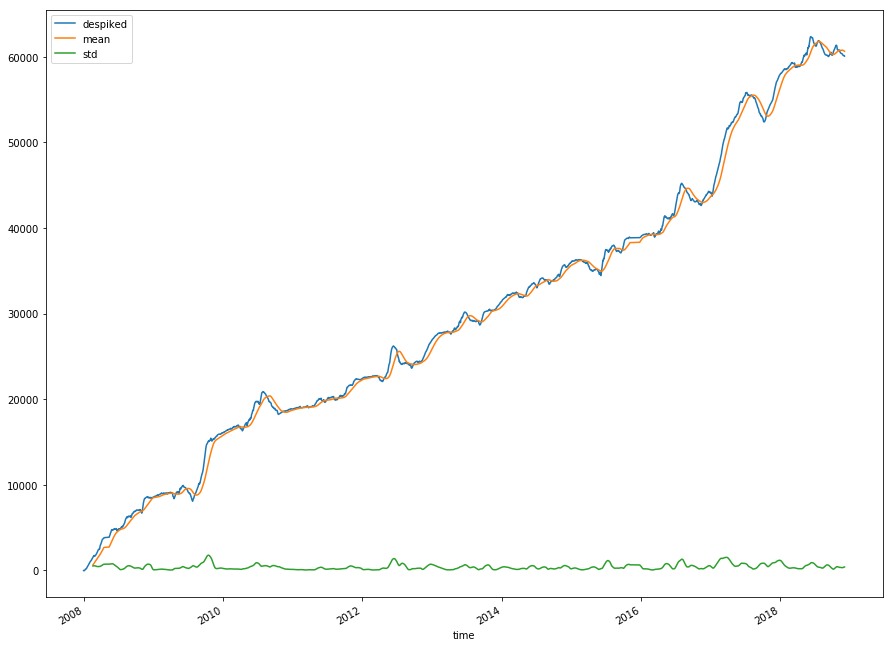

In [5]:
# test stationary
res = tsa.adfuller(data['despiked'].values)
tsa.print_adf(res,'despiked data')
data['mean'] = data['despiked'].rolling(window=window_size).mean()
data['std'] = data['despiked'].rolling(window=window_size).std()
data.plot(figsize=(15,12),y=['despiked','mean','std'])

In [6]:
# detrend
data['detrend'] = tsa.detrend(data['despiked'])

Augmented Dickey–Fuller test for detrended data:
  adf: -2.4215170263186088
  p-value: 0.13575524964385655
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


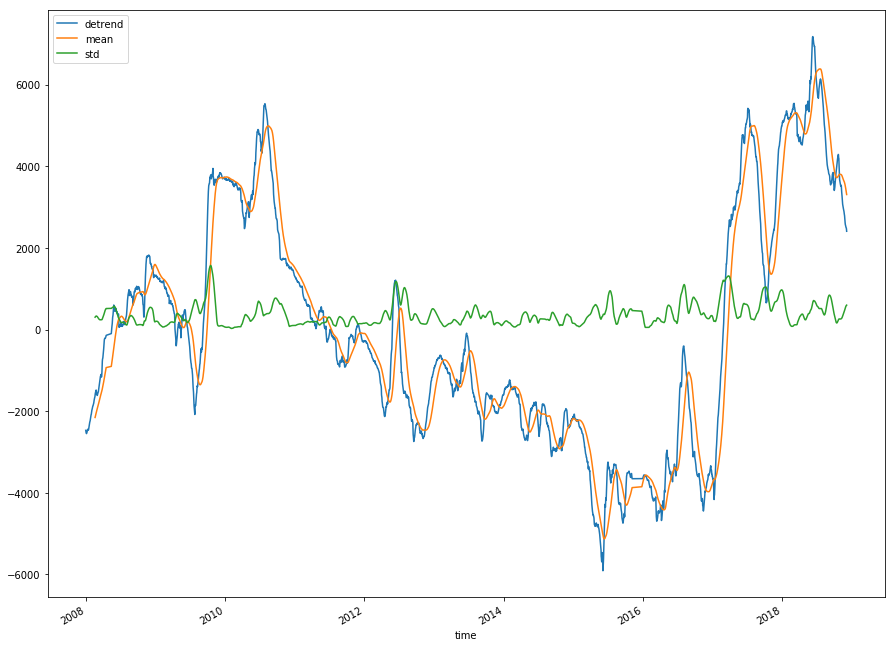

In [7]:
# test stationary again
res = tsa.adfuller(data['detrend'].values)
tsa.print_adf(res,'detrended data')
data['mean'] = data['detrend'].rolling(window=window_size).mean()
data['std'] = data['detrend'].rolling(window=window_size).std()
data.plot(figsize=(15,12),y=['detrend','mean','std'])

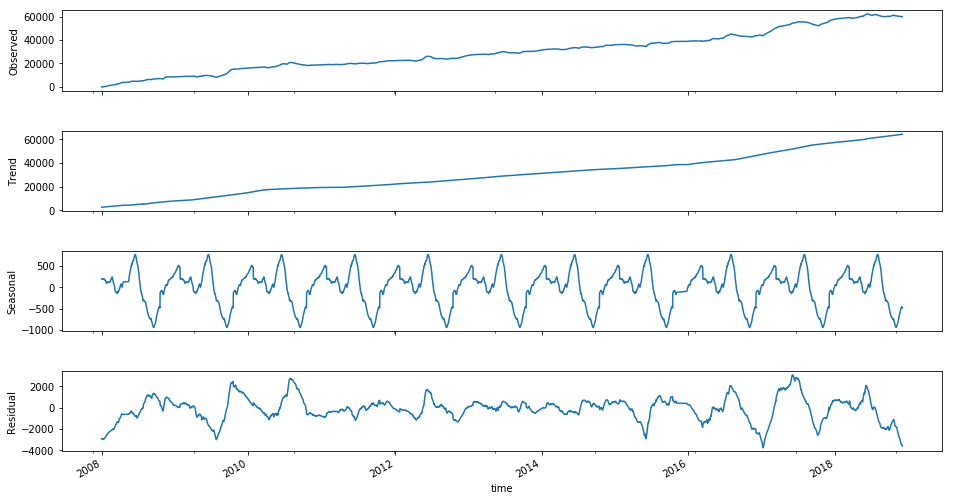

In [21]:
# seasonal decomposition
period = 365
na_values_output = np.nan

decomposition = tsa.seasonal_decompose(data['despiked'],freq=period,extrapolate_trend='freq')

fig=decomposition.plot()
fig.set_size_inches(15,8)
#plt.savefig(pathlib.Path(res_pic))

data['trend'] = decomposition.trend.fillna(na_values_output)
data['seasonal'] = decomposition.seasonal.fillna(na_values_output)
data['residual'] = decomposition.resid.fillna(na_values_output)

Augmented Dickey–Fuller test for residual data:
  adf: -5.373578658946293
  p-value: 3.848002048806779e-06
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


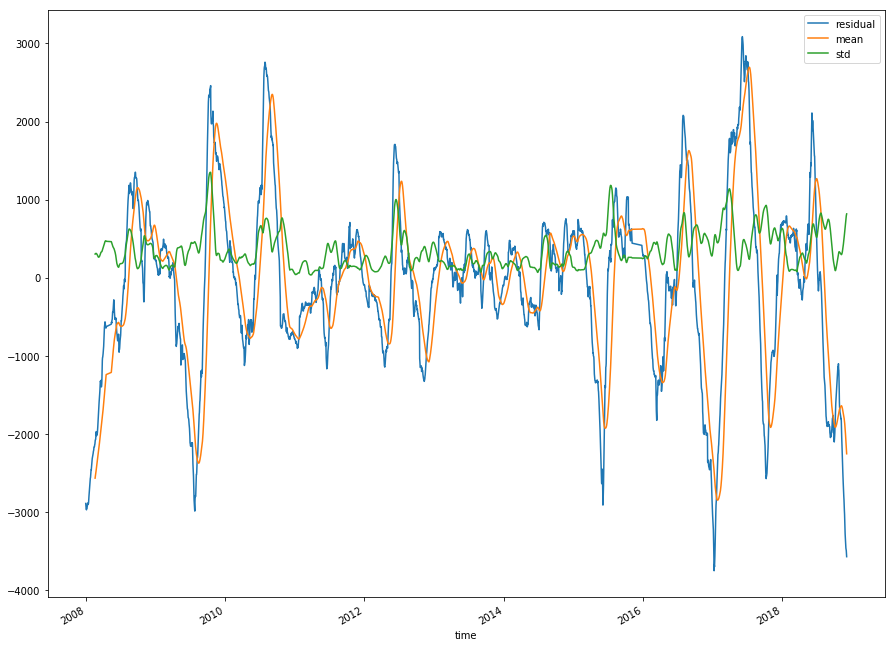

In [22]:
# test stationary on residual
res = tsa.adfuller(data['residual'].dropna().values)
tsa.print_adf(res,'residual data')
data['mean'] = data['residual'].rolling(window=window_size).mean()
data['std'] = data['residual'].rolling(window=window_size).std()
data.plot(figsize=(15,12),y=['residual','mean','std'])

In [23]:
# ARIMA
p = 5
d = 0
q = 1
P = 0
D = 0
Q = 0
s = 0
model = tsa.SARIMAX(data['residual'].dropna(),
                    order=(p,d,q),
                    seasonal_order=(P,D,Q,s),
                    enforce_stationarity=False)
res = model.fit()
pred = res.get_forecast(180)
pci = pred.conf_int()



/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


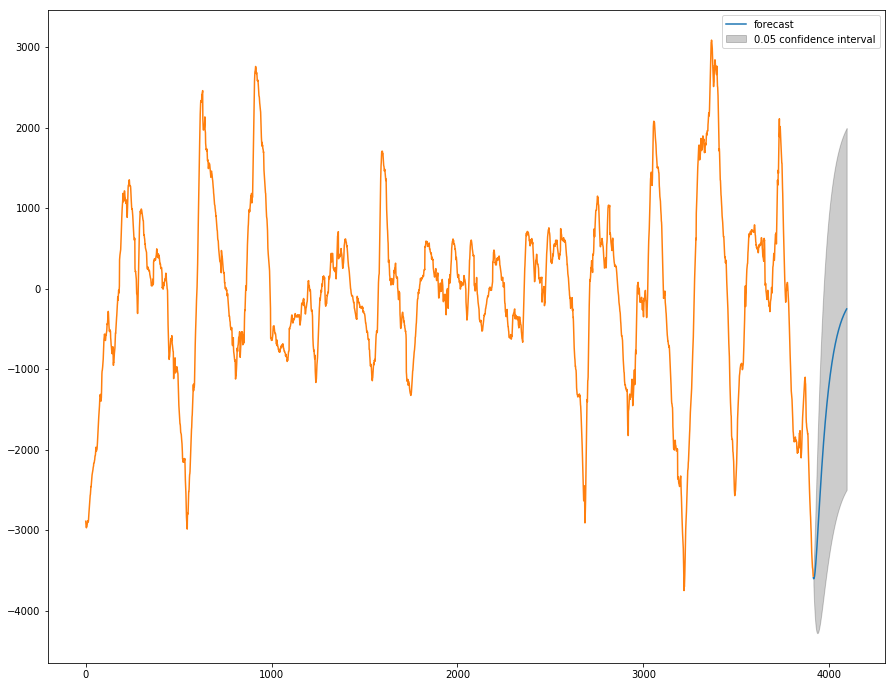

In [24]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
pred.predicted_mean.plot(ax=ax,label='forecast')
ax.fill_between(pci.index,pci.iloc[:,0],pci.iloc[:,1],color='k',alpha=0.2,label='0.05 confidence interval')
ax.plot(data['residual'].dropna().values)
ax.legend()

In [14]:
data['residual']

time
2008-01-01   NaN
2008-01-02   NaN
2008-01-03   NaN
2008-01-04   NaN
2008-01-05   NaN
2008-01-06   NaN
2008-01-07   NaN
2008-01-08   NaN
2008-01-09   NaN
2008-01-10   NaN
2008-01-11   NaN
2008-01-12   NaN
2008-01-13   NaN
2008-01-14   NaN
2008-01-15   NaN
2008-01-16   NaN
2008-01-17   NaN
2008-01-18   NaN
2008-01-19   NaN
2008-01-20   NaN
2008-01-21   NaN
2008-01-22   NaN
2008-01-23   NaN
2008-01-24   NaN
2008-01-25   NaN
2008-01-26   NaN
2008-01-27   NaN
2008-01-28   NaN
2008-01-29   NaN
2008-01-30   NaN
              ..
2018-11-05   NaN
2018-11-06   NaN
2018-11-07   NaN
2018-11-08   NaN
2018-11-09   NaN
2018-11-10   NaN
2018-11-11   NaN
2018-11-12   NaN
2018-11-13   NaN
2018-11-14   NaN
2018-11-15   NaN
2018-11-16   NaN
2018-11-17   NaN
2018-11-18   NaN
2018-11-19   NaN
2018-11-20   NaN
2018-11-21   NaN
2018-11-22   NaN
2018-11-23   NaN
2018-11-24   NaN
2018-11-25   NaN
2018-11-26   NaN
2018-11-27   NaN
2018-11-28   NaN
2018-11-29   NaN
2018-11-30   NaN
2018-12-01   NaN
2018-12-0